# Sparse Coding Tutorial

The goal of the tutorial is to use Sparse Coding to understand the "features" which make-up handwritten digits. This sort of analysis is common when looking at natural signals (images) and also neuroscience data (LFP).

Most of the code has been written so you'll be running and the code, looking and the plots, and manipulating some of the variables to understand how they affect the results. You should work in small groups (2-3) and go through the different sections of the notebook. Questions are highlighted in <font color='green'>green</font> throughout the notebook.

We'll check-in halfway through to make sure everyone is making progress.

# Using IPython Notebooks

IPython notebooks are made up of a number of 'cells'. Each cell can either run some python code or contain text.

To run a cell, click on it or move to it with up and down arrows and press 'Shift + Enter'. Alternatively, you can press the 'play' button in the toolbar. Any output from the cell (text or plots) will apprear below the cell after you run it Try running the cell below!

In [ ]:
print "Hello World!"

Before you can do much in Python, you'll probably need to import one or a few libraries. NumPy is a matrix library that is used in scientific python applications. The 'import X as Y' statement loads a library X under the alias Y.

In [ ]:
import numpy as np

IPython can tell you about the properties of functions and modules/libraries. One way to get this is to 'tab complete'. Given a library, 'np', you can query the function in the library by typing 'np.' and pressing 'Tab'. Give it a try! You need have imported numpy for this information to be available, so before trying this make sure you've executed the previous cell.

In [ ]:
np.

To learn about a function, you can type the functions name then a question mark and run the cell.

In [ ]:
np.zeros?

# Positive Only Sparse Coding on MNIST

This code implements Positive Only Sparse Coding on MNIST.

Lets break that down.

Sparse Coding is an algorithm that seeks to disentangle the underlying generative factors of data. In this particular case, we are considering the dataset, MNIST, which is a collection of digits. Intuitively speaking, the underlying generative factors of digits are pen strokes. When these strokes are combined in the right way, we get digits. We will see that sparse coding discovers this underlying structure. 

In sparse coding, we define the following:
$I$ is an image, $D$ is a dictionary of underlying generative factors, and $A$ the sparse coefficients. We seek to write our image as a weighted sum of the dictionary elements. In equation form, 

$$I(x) = d_1(x) * a_1 + d_2(x) * a_2 + \ldots$$

where the dictionary elements are the same for any image in the data set, and the coefficients, $a$, are different for each image. 

In order to learn the dictionary elements $D$, and the sparse coefficients, $A$, we minimize the following objective function:

$$E = |I - A * D| ^ 2 + |A|_1 \qquad \sum_x d_i(x)^2 = 1$$

(Note $D$ is number of dictionary elements by the number of pixels). To minimize this function, we do the following steps:

0. Choose an initial value of $D$.

1. Choose a batch of images $I$.

2. Minimize $E$ with respect to $A$ - we use FISTA which is a slighly better version of gradient descent.

3. Keeping that value of $A$, change $D$ one gradient step to reduce the value of $E$.

4. Return to step 1. 

### Import libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from scipy.io import savemat, loadmat
from scipy.stats import probplot, expon, norm, halfnorm

from utils.rf_plot import show_fields

from network import Network

### Load Data

In [2]:
data_dir = "data/"
data_file = "mnist.mat"
output_dir = 'output/'

data = loadmat(data_dir + data_file)
IMAGES = data['IMAGES']
LABELS = data['LABELS']

# Set basic parameters
(K, L_img, L_img) = IMAGES.shape
print('Number of images: '+str(K))
K # Number of base images
L_img # Linear size of images from the data
N_pix_img = L_img ** 2

# Scale the images to have a constant standard deviation
IMAGES = IMAGES / np.std(IMAGES.astype(float), axis = (1, 2), keepdims = True)
data = IMAGES.reshape(-1, N_pix_img)
order = np.random.permutation(data.shape[0]) # Permute the data since they are sorted by digit
data = data[order]

Number of images: 60000


### 1) Create Sparse Coding Network

In [3]:
pos_only = True # Positive Only Sparse coding if True
N_sp = 81 # Number of sparse dictionary elements
lamb = 0.5 # Sparsity parameter (0.5 is a good value, too large and you'll get NaNs)
eta = 0.05 # Dictionary Learning Step Size

net = Network(N_sp, N_pix_img, lamb, eta)

Inspect the functions in the network.

In [ ]:
net.

Visualize the untrained dictionary

In [ ]:
show_fields(net.D, pos_only = True)
plt.title('Dictionary')

Run inference on the network

In [ ]:
A, costs = net.infer_A(data[0:100], n_g_steps=150, track_cost=True)
plt.plot(np.log(costs))
plt.title('Cost During Inference')
plt.xlabel('Iteration')
plt.ylabel('Log-Cost')

<font color='green'>1) How was the dictionary initialized? What does the dictionary mean? What is the biological analogue for vision?
<br>
2) What is the inference step supposed to do? Is it working?</font>

### 2) Train the Network

Train the network and visualize the dictionary elements.

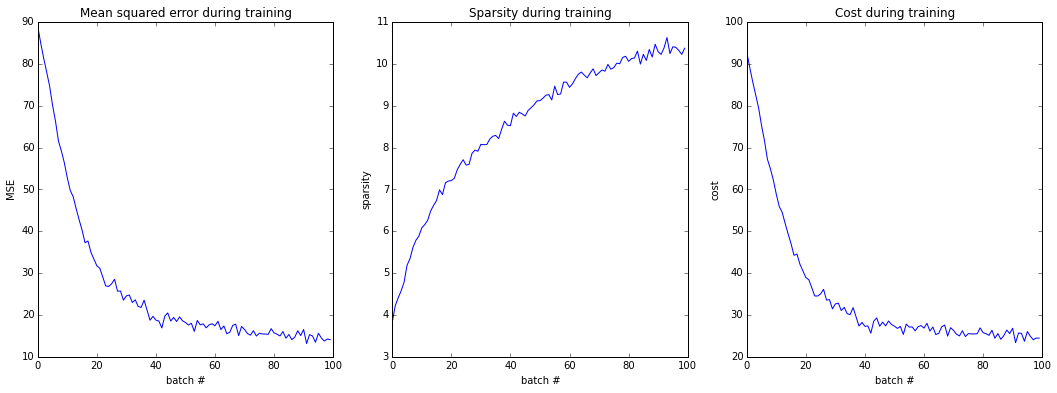

In [4]:
[MSE_hist, sparsity_hist, SNR_hist, cost_hist] = net.train(data, reset=False, batch_size=100, n_batches=100, eta = eta)

plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.plot(MSE_hist)
plt.title('Mean squared error during training')
plt.xlabel('batch #')
plt.ylabel('MSE')

plt.subplot(1, 3, 2)
plt.plot(sparsity_hist)
plt.title('Sparsity during training')
plt.xlabel('batch #')
plt.ylabel('sparsity')

plt.subplot(1, 3, 3)
plt.plot(cost_hist)
plt.title('Cost during training')
plt.xlabel('batch #')
plt.ylabel('cost')


Plot the dictionary elements.

In [ ]:
show_fields(net.D, cmap='gray', pos_only=True)
plt.title('Dictionary')

<font color='green'>1) What happens to MSE, sparsity, and the Cost during training?
<br>
2) What do the dictionary elements look like? What happens if you run the training cell multiple times? What happens to the dictionary as you train it more?</font>

### 3) Network Analysis

Visualize the reconstructions in more detail for a particular image

In [ ]:
plt.figure(figsize=(8,8))
q = np.random.randint(net.A.shape[0])
plt.subplot(2, 2, 1)
plt.title('Reconstruction')
plt.imshow(net.reconstruct(net.X, net.A)[q].reshape(L_img, L_img),
           interpolation = 'nearest',
           cmap = plt.cm.gray, vmin = 0, vmax = net.X[q].reshape(L_img, L_img).max())
plt.colorbar()
plt.subplot(2, 2, 2)
plt.title('Orignal Image')
plt.imshow(net.X[q].reshape(L_img, L_img),
           interpolation = 'nearest',
           cmap = plt.cm.gray)
plt.colorbar()
plt.subplot(2, 2, 3)

plt.hist(net.A[q])

sort_idx = np.argsort(net.A[q])[::-1]
N_active = np.sum(net.A[q] > 0.0)
active_idx = sort_idx[0:N_active]

plt.title('Histogram of sparse Coefficients: \n Number of active coefficients %d' % N_active)
plt.xlabel('Coefficient Activity')

plt.subplot(2, 2, 4)
show_fields(net.D[active_idx] * 
            net.A[q][active_idx][:, np.newaxis], 
            cmap = plt.cm.gray, pos_only = True)
plt.title('Active Dictionary Elements \n Scaled by their activations')

<font color='green'>1) How well is the network reconstructing the image?
<br>
2) How are the coefficient values distributed? Why are they distributed this way?
<br>
3) How is the bottom-right plot related to the reconstruction?</font>

Look at the joint statistics between different sparse coefficients

In [21]:
n_digits = 10000
A = net.infer_A(data[np.random.randint(0, data.shape[0], n_digits), :])

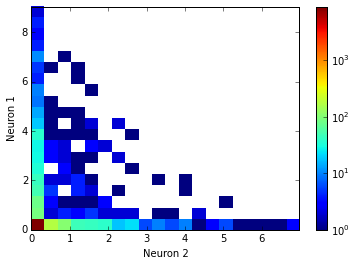

In [25]:
n1, n2 = np.random.permutation(net.A.shape[1])[:2]
_ = plt.hist2d(A[:,n1], A[:,n2], 20, norm=LogNorm())
plt.colorbar()
plt.xlabel('Neuron 2')
plt.ylabel('Neuron 1')

<font color='green'>1) How are the coefficients distributed? Everytime you run the plot, it will choose different pairs of neurons.
<br>
2) How would this plot look if the coefficients were from a normal distribution?</font>

Check that the distribution of non-zero coefficients is exponentially distributed using a probability plot. 

In [ ]:
As = net.A.ravel()
p = probplot(As[As > 0], dist = expon, plot = plt)

<font color='green'>1) How well does the distribution line up with samples drawn from an exponential distribution?
<br>
2) How well does it match if you change "expon" to "norm" or "halfnorm"?</font>

# Recap<br>
<font color='green'> If you have time left go back and change the sparsity weight (lamb) to be larger or smaller. <br>
1) What happens to the sparsity? What happens to the reconstruction error? <br>
2) What do the dictionaries look like?</font>

# Details on FISTA (Optional)

Since the objective function has an absolute value, typical gradient descent approaches converge slowly. Thus there are special purpose gradient descent methods that minimize functions that are in the form $$f(x) + g(x)$$ where $f(x)$ is a continuously differentiable, convex function and $g(x)$ is a convex, but not continuously differentiable function, such as $g(x) = \alpha |x|$. One such method is called FISTA, or the Fast Iterative Shrinkage-Threshold Algorithm. 

The core kernel of the FISTA algorithm is the ISTA step:

Define
$$p_L(y) = \text{argmin}_x \, g(x) + L/2 * ||x- g(y)||^2$$ where $$g(y) = y - \frac{1}{L} \nabla f(y)$$

and where $L$ is the constant such that $$||\nabla f(x) - \nabla f(y)|| \le L ||x - y||$$

When $g(x) = \alpha|x|_1$, then $$p_L(y) = h_\theta(g(y))\qquad h_\theta(y) = \text{sign}(y)(|y|-\theta)\qquad \theta = \frac{\alpha}{L}$$
$h$ is applied pointwise its input and is called the shrinkage function. Simplying calculating $x_{t+1} = p_L(x_t)$ is the ISTA algorithm. If we more intelligently choose our new value to probe our function, then we get faster convergence. The FISTA algorithm is as follows:

1. Initialize $y_0 = x_0 = X0$, $t_0=1$. 

2. For $k \ge 0$, iterate the following:

$$x_{k+1} = p_L(y_k)\qquad t_{k+1} = 0.5 * (1 + \sqrt{1 + 4 * t_k ^2})\qquad y_{k+1} = x_{k+1} + \frac{t_k - 1}{t_{k+1}} * (x_{k+1} - x_k)$$